In [33]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import random
import shutil
import torchvision.datasets as datasets
import torchvision
import tqdm
import sklearn
import sklearn.datasets
from tensorboardX import SummaryWriter

In [4]:
GPU_MODE = False
data_dir = 'data/'

In [5]:
classes = ['healthy', 'Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 
           'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_mosaic_virus', 
          'Tomato_Yellow_Leaf_Curl_Virus']
binary_classes = ['healthy', 'non_healthy']

if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
os.mkdir(data_dir + 'test')
os.mkdir(data_dir + 'test/healthy')

shutil.copytree("original_dataset/healthy", data_dir + "train/healthy")
for i in range(int(len(os.listdir(data_dir + 'train/healthy')) * 0.2)): #testing parameter
    src = random.choice(os.listdir(data_dir + "train/healthy"))
    shutil.move(data_dir + "train/healthy/" + src, data_dir + "test/healthy/" + src)
    
os.mkdir(data_dir + 'train/non_healthy')
os.mkdir(data_dir + 'test/non_healthy')
for cls in tqdm.tqdm(list(classes[1:])):
    for i in range(133):
        src = random.choice(os.listdir("original_dataset/" + cls))
        shutil.copyfile("original_dataset/" + cls + '/' + src, data_dir + "train/non_healthy/" + src)#will become copytree
    for i in range(33):
        src = random.choice(os.listdir(data_dir + "train/non_healthy"))
        shutil.move(data_dir + "train/non_healthy/" + src, data_dir + "test/non_healthy/" + src)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.30it/s]


In [6]:
batch_size = 16
data_transforms = {
        'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms[x]) for x in ['train', 'test']}
trainloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                         shuffle=True, num_workers=8)

non_healthy non_healthy healthy healthy healthy non_healthy non_healthy healthy non_healthy non_healthy healthy non_healthy non_healthy healthy healthy non_healthy


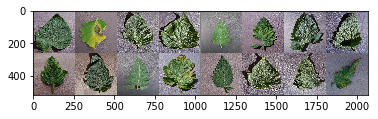

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % binary_classes[labels[j]] for j in range(batch_size)))

In [26]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 3 input image channel,
        # 6 output channel,
        # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 6, 5)
        self.conv3 = nn.Conv2d(6, 16, 5)
        # an affine operation
        self.fc1 = nn.Linear(16 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        # max pooling over a (2, 2) windows
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = Model()
if GPU_MODE:
    model = model.cuda()
    
print(model)

Model(
  (conv1): Conv2d (3, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (4, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=2)
)


In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 1
num_batches = 32
num_iterations = 0

log_dir = 'log/'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)

for epoch in tqdm.tqdm(list(range(num_epochs))):  # loop over the dataset multiple epochs

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        if GPU_MODE:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad() # zero the gradient buffers

        # forward + loss + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # does the update

        # print statistics
        running_loss += loss.data[0]
        if i % num_batches == num_batches - 1:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / num_batches))
            num_iterations += i
            writer.add_scalar('train/loss', running_loss, num_iterations)
            running_loss = 0.0
        
print('Finished Training.')

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'log/events.out.tfevents.1524558696.JARVIS'

GroundTruth:  non_healthy non_healthy healthy healthy healthy non_healthy healthy healthy non_healthy healthy healthy healthy healthy healthy non_healthy non_healthy


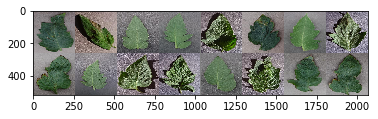

In [46]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % binary_classes[labels[j]] for j in range(16)))

In [12]:
if GPU_MODE:
    outputs = model(Variable(images).cuda())
else:
    outputs = model(Variable(images))

_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % binary_classes[predicted.cpu()[j]]
                              for j in range(16)))

Predicted:  healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy healthy


In [30]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 51 %


In [31]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
for data in testloader:
    images, labels = data
    if GPU_MODE:
        outputs = model(Variable(images).cuda())
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted.cpu() == labels).squeeze()
    else:
        outputs = model(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        c = (predicted == labels).squeeze()
    for i in range(2):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (binary_classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of healthy : 100 %
Accuracy of non_healthy :  0 %
